# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Selecting previously unselected package xvfb.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

2 (4,)


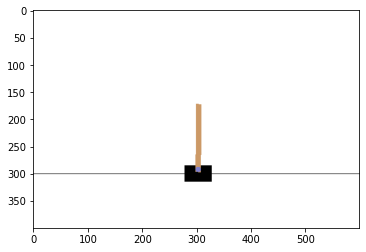

In [3]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

print(n_actions, state_dim)

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (`L.Dense`) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: since agent's observations are not normalized, sigmoids might be saturated at initialization. Instead, use non-saturating nonlinearities like ReLU.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [4]:
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

#import keras
#import keras.layers as L
#keras.backend.set_session(sess)

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(state_dim),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(n_actions)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
l = np.array([4,1,4])
print('l = ',l)
print('l[None] = ',l[None])
print('[l] = ',[l])
print('(l[None])[0] = ',(l[None])[0])

l =  [4 1 4]
l[None] =  [[4 1 4]]
[l] =  [array([4, 1, 4])]
(l[None])[0] =  [4 1 4]


In [7]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    q_values = model.predict(state[None])[0]
    
    rn = np.random.random()
    a = np.argmax(q_values) if rn > epsilon else np.random.choice(n_actions)

    return a

In [8]:
assert model.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert model.layers[-1].activation == tf.keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    print(state_frequencies)

    best_action = state_frequencies.argmax()
    x = abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions))
    print(x)
    
    assert x < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

[10000     0]
0.0
e=0.0 tests passed
[9499  501]
1.0
e=0.1 tests passed
[7524 2476]
24.0
e=0.5 tests passed
[4935 5065]
65.0
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doing backprop".

In [9]:
x = (None, ) + state_dim
print(state_dim)
print(x)

y = (None, ) + (4,3,)
print(y)

(4,)
(None, 4)
(None, 4, 3)


In [10]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = tf.keras.backend.placeholder(dtype='float32', shape=(None,) + state_dim)
actions_ph = tf.keras.backend.placeholder(dtype='int32', shape=[None])
rewards_ph = tf.keras.backend.placeholder(dtype='float32', shape=[None])
next_states_ph = tf.keras.backend.placeholder(dtype='float32', shape=(None,) + state_dim)
is_done_ph = tf.keras.backend.placeholder(dtype='bool', shape=[None])

In [11]:
l = [0,1,0,1]
d = np.unique(l)
t = tf.one_hot(l, len(d), dtype='int32')
print(sess.run(t))
print()

#Compoment-wise product
pred_qv = tf.constant([[11, 0],[0, 12], [15, 0], [0, 16] ], dtype='int32')
print(sess.run(pred_qv * t))
print()

print(sess.run(tf.reduce_sum(pred_qv, axis=1)))

[[1 0]
 [0 1]
 [1 0]
 [0 1]]

[[11  0]
 [ 0 12]
 [15  0]
 [ 0 16]]

[11 12 15 16]


In [12]:
# Model branch 1

#get q-values for all actions in current states
predicted_qvalues = model(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

In [13]:
gamma = 0.99

# Model branch 2

# compute q-values for all actions in next states
# YOUR CODE: apply network to get q-values for next_states_ph>
predicted_next_qvalues = model(next_states_ph)

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

# compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
target_qvalues_for_actions = rewards_ph + gamma * next_state_values

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
#mean squared error loss to minimize
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
loss = tf.reduce_mean(loss)

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [15]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

### Playing the game

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
def generate_session(env, t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done:
            break
            
    return total_reward

In [18]:
epsilon = 0.5

for i in range(1000):
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

epoch #0	mean reward = 19.750	epsilon = 0.500
epoch #1	mean reward = 13.260	epsilon = 0.495
epoch #2	mean reward = 15.100	epsilon = 0.490
epoch #3	mean reward = 14.570	epsilon = 0.485
epoch #4	mean reward = 14.410	epsilon = 0.480
epoch #5	mean reward = 15.900	epsilon = 0.475
epoch #6	mean reward = 16.980	epsilon = 0.471
epoch #7	mean reward = 21.010	epsilon = 0.466
epoch #8	mean reward = 23.300	epsilon = 0.461
epoch #9	mean reward = 23.050	epsilon = 0.457
epoch #10	mean reward = 31.020	epsilon = 0.452
epoch #11	mean reward = 38.330	epsilon = 0.448
epoch #12	mean reward = 41.930	epsilon = 0.443
epoch #13	mean reward = 41.870	epsilon = 0.439
epoch #14	mean reward = 52.770	epsilon = 0.434
epoch #15	mean reward = 67.200	epsilon = 0.430
epoch #16	mean reward = 66.740	epsilon = 0.426
epoch #17	mean reward = 72.850	epsilon = 0.421
epoch #18	mean reward = 101.380	epsilon = 0.417
epoch #19	mean reward = 129.330	epsilon = 0.413
epoch #20	mean reward = 151.840	epsilon = 0.409
epoch #21	mean rewar

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [19]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, epsilon=0, train=False) for _ in range(100)]

In [20]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices